In [1]:
import random
import numpy as np
from copy import deepcopy

In [2]:
board = ['.'for i in range(9)]
board[4] = 'X'

In [3]:
def Board_show(board):
    for i in range(3):
        print(board[i*3:i*3+3])
    print('')

In [4]:
class Node:
    def __init__(self,board,parent,player):
        self.children = list()
        self.parent = parent
        self.R = 0
        self.N = 0
        self.state = board
        self.move  = list()
        self.player = player # True for opponent i.e. root.player = True
        
    def is_terminal(self):
        state = self.state
        if '.' not in state:
            return True
        for i in range(3):
            if state[0+3*i] == state[1+3*i] and state[0+3*i] == state[2+3*i] and state[0+3*i]!='.':
                return True
            if state[0+i] == state[3+i] and state[0+i] == state[6+i] and state[0+i]!='.':
                return True
        if state[0] == state[4] and state[0] == state[8] and state[0]!='.':
            return True
        if state[2] == state[4] and state[2] == state[6] and state[2]!='.':
            return True
        return False
    
    def get_reward(self):
        if not self.is_terminal(): 
            raise Exception("Sorry, game is not over (get reward)")
        state = self.state
        for i in range(3):
            if state[0+3*i] == state[1+3*i] and state[0+3*i] == state[2+3*i] and state[0+3*i]=='O':
                return 1
            if state[0+i] == state[3+i] and state[0+i] == state[6+i] and state[0+i]=='O':
                return 1
        if state[0] == state[4] and state[0] == state[8] and state[0]=='O':
            return 1
        if state[2] == state[4] and state[2] == state[6] and state[2]=='O':
            return 1
        return 0
    
    def get_move(self):
        state = self.state
        return [i for i,x in enumerate(state) if x=='.']
    
    def get_uct(self):
        c = 2
        if self.N == 0 or self.parent.N == 0:
            return 1e10
        else:
            return self.R/self.N + np.sqrt(c)*np.sqrt(np.log(self.parent.N)/self.N)
    
    def new_children(self):
        if self.is_terminal():
            raise Exception('Sorry, game is over (new children)')
        self.move = self.get_move()
        state = self.state
        if self.player:
            for action in self.move:
                new_state = deepcopy(state)
                new_state[action] = 'O'
                parent = self
                self.children.append(Node(new_state,parent,False))
        else:
            for action in self.move:
                new_state = deepcopy(state)
                new_state[action] = 'X'
                parent = self
                self.children.append(Node(new_state,parent,True))
    
    def update(self,reward):
        self.N = self.N+1
        self.R = self.R+reward
        
    def get_Qvalue(self):
        node = self
        Q = 0
        if node.is_terminal():
            return node.R/node.N
        else:
            Qlist = []
            if node.children:
                for child in node.children:
                    if child.N !=0:
                        Q = Q + child.N/node.N*child.get_Qvalue()
#                     Qlist.append(child.get_Qvalue())
#                 child_ids = Qlist.index(max(Qlist))
#                 child = node.children[child_ids]
#                 return child.N/node.N*max(Qlist)
                return Q
#             else:
#                 Board_show(node.state)
#                 raise Exception('Tree is not fully built')
                
        

In [5]:
class tttTree:
    def __init__(self,root):
        self.root = root
        
    def rollout(self,node):
        node = node
        if node.is_terminal():
            return node.get_reward(),node
        while not node.is_terminal():
            if node.children == []:
                node.new_children()
            node = np.random.choice(node.children)
            #Board_show(node.state)
            
        return node.get_reward(),node #leaf node
    
    def backward(self,reward,leaf):
        if not leaf.is_terminal():
            raise Exception('Sorry, game is not over (backward)')
        while leaf:
            leaf.update(reward)
            leaf = leaf.parent
    
    def expansion(self,node):
        if node.is_terminal():
            return node
        if node.children == []:
            node.new_children()
            return np.random.choice(node.children)
        else:
            raise Exception('sorry, this node is not leaf node')
            
    def choose(self):
        node = self.root
        #maybe not choose选到Leaf为止，可能root也需要
#         if node.children == []:
#             node.new_children()
        while node.children:
#             if True:
            if node.player:
                leaf = node.children[0]
                uct = leaf.get_uct()
#                 uct = 0
                for child in node.children:
                    if uct<child.get_uct():
                        leaf = child
                        uct = child.get_uct()
                node = leaf
                
            else:
                node = np.random.choice(node.children)
        return node

    def game(self):
        node = self.choose()
        node = self.expansion(node)
        reward,leaf = self.rollout(node)
        self.backward(reward,leaf)
        
        

In [6]:
root = Node(board,None,True)
tree = tttTree(root)
q_list = [0]
iteration = [0]

In [7]:
for _ in range(5000):
    tree.game()
q_list.append(tree.root.get_Qvalue())
iteration.append(5000)

In [8]:
old_q = tree.root.get_Qvalue()
tree.game()
# print(tree.root.get_Qvalue()-old_q)
k = 2
while np.abs(tree.root.get_Qvalue()-old_q) > 0.000001:
    
    for i in range(4999):
        tree.game()
    old_q = tree.root.get_Qvalue()
    tree.game()
    q_list.append(tree.root.get_Qvalue())
    iteration.append(5000*k)
    k = k+1
    #print(tree.root.get_Qvalue()-old_q)

In [9]:
tree.root.N

200001

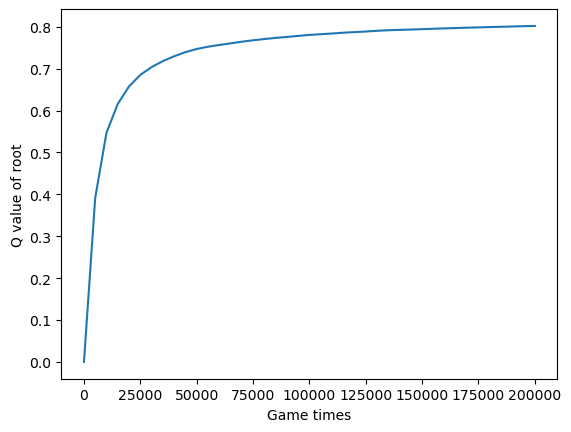

In [10]:
import matplotlib.pyplot as plt
plt.plot(iteration,q_list)
plt.xlabel('Game times')
plt.ylabel('Q value of root')
plt.savefig('visual Q.jpg')

### check balance

In [21]:
for child in tree.root.children:
    print("visits:",child.N,",wins:",child.R,"ucb:",child.get_uct())
    Board_show(child.state)

visits: 198397 ,wins: 160108 ucb: 0.8181008256305211
['O', '.', '.']
['.', 'X', '.']
['.', '.', '.']

visits: 263 ,wins: 54 ucb: 0.5099900336542442
['.', 'O', '.']
['.', 'X', '.']
['.', '.', '.']

visits: 197 ,wins: 33 ucb: 0.5195348061453121
['.', '.', 'O']
['.', 'X', '.']
['.', '.', '.']

visits: 226 ,wins: 42 ucb: 0.5145022150558936
['.', '.', '.']
['O', 'X', '.']
['.', '.', '.']

visits: 147 ,wins: 18 ucb: 0.5299647260513881
['.', '.', '.']
['.', 'X', 'O']
['.', '.', '.']

visits: 363 ,wins: 88 ucb: 0.5017524447166842
['.', '.', '.']
['.', 'X', '.']
['O', '.', '.']

visits: 220 ,wins: 40 ucb: 0.5149312890835352
['.', '.', '.']
['.', 'X', '.']
['.', 'O', '.']

visits: 188 ,wins: 30 ucb: 0.5199241452681624
['.', '.', '.']
['.', 'X', '.']
['.', '.', 'O']



## visual most successful node (biggest R)

In [12]:
nodes = []
node = tree.root
print('N: ',node.N,'R: ',node.R)
Board_show(node.state)
nodes.append(node)
while node.children:
    c = node.children[0]
    for child in node.children:
        if child.R > c.R:
            c = child
    node = c
    print('N: ',node.N,'R: ',node.R,'UCT: ',node.get_uct())
    Board_show(node.state)
    nodes.append(node)

N:  200001 R:  160413
['.', '.', '.']
['.', 'X', '.']
['.', '.', '.']

N:  198397 R:  160108 UCT:  0.8181008256305211
['O', '.', '.']
['.', 'X', '.']
['.', '.', '.']

N:  28324 R:  25894 UCT:  0.9435553005358165
['O', '.', '.']
['.', 'X', '.']
['.', 'X', '.']

N:  27936 R:  25717 UCT:  0.9476594928392881
['O', 'O', '.']
['.', 'X', '.']
['.', 'X', '.']

N:  5652 R:  5577 UCT:  1.0469189988720446
['O', 'O', '.']
['.', 'X', '.']
['.', 'X', 'X']

N:  3081 R:  3081 UCT:  1.0748893579379772
['O', 'O', 'O']
['.', 'X', '.']
['.', 'X', 'X']



## visual a game by 'choose'(choose node by uct)

In [13]:
node = tree.choose()
nodes = [node]
while node.parent:
#     Board_show(node.state)
#     print(node.N,node.R)
    node = node.parent
    nodes.append(node)

In [20]:
print("==================================================================")
for i in range(len(nodes)-1,-1,-1):
    node = nodes[i]
    if i == 5:
        print('N: ',node.N,'R: ',node.R ,'Q: ',node.get_Qvalue())
    else:
        print('N: ',node.N,'R: ',node.R,'Q: ',node.get_Qvalue(),'UCB: ',node.get_uct())
    Board_show(node.state)
    print("==================================================================")

N:  200001 R:  160413 Q:  0.8020609896950515
['.', '.', '.']
['.', 'X', '.']
['.', '.', '.']

N:  198397 R:  160108 Q:  0.8070081704864489 UCB:  0.8181008256305211
['O', '.', '.']
['.', 'X', '.']
['.', '.', '.']

N:  28279 R:  24008 Q:  0.8489691997595391 UCB:  0.8783408088640889
['O', '.', '.']
['.', 'X', '.']
['X', '.', '.']

N:  27976 R:  23903 Q:  0.854410923648842 UCB:  0.8814805005395968
['O', '.', 'O']
['.', 'X', '.']
['X', '.', '.']

N:  5612 R:  5531 Q:  0.9855666429080542 UCB:  1.0459736205710013
['O', '.', 'O']
['.', 'X', '.']
['X', 'X', '.']

N:  5430 R:  5430 Q:  1.0 UCB:  1.0563881001814288
['O', 'O', 'O']
['.', 'X', '.']
['X', 'X', '.']

